# PCLab#1 - Group 7 - Mark Levin, Jakub Nahorny, Ian Ronk, Gianfranco Salocchi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sb
from scipy.optimize import minimize

## Task 1. Import the data and describe the sample
### 1. Sort the stock data by date and print the number of stocks

In [2]:
df = pd.read_csv('data/Data_PCLab1_Stock.csv')

In [3]:
df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [4]:
# Check if the data is already sorted by date
df['Date'].is_monotonic_increasing

True

In [5]:
# The number of stocks is the number of columns minus two ('Date' is the date column and 'sp500' is an index, not a stock)
df.shape[1] - 2

8

### 2. Check if data contains any null values

In [6]:
# Print the number of null values by column
for col in df.columns:
    print(col, df[col].isna().sum())

Date 0
AAPL 0
BA 0
T 0
MGM 0
AMZN 0
IBM 0
TSLA 0
GOOG 0
sp500 0


### 3. What is the average market value of the S&P500 ?

In [7]:
df['sp500'].mean()

2218.7495540592868

### 4. Which stock or index has the minimum dispersion in dollar value?

In [8]:
cols = [col for col in df.columns if col != 'Date']
stds = [df[col].std() for col in cols] # We are going to use standard deviation as the dispersion measure
cols_stds = {k: v for k, v in zip(cols, stds)}

In [9]:
min_dispersion_tick = min(cols_stds, key=cols_stds.get)
min_dispersion = cols_stds[min_dispersion_tick]
print(f'{min_dispersion_tick} has the minimum dispersion: {min_dispersion}')

T has the minimum dispersion: 3.2074898522656086


### 5. What is the maximum price for Amazon stock over the specified time period?

In [10]:
df.loc[df['AMZN'].idxmax()][['Date', 'AMZN']]

Date    2020-08-06
AMZN        3225.0
Name: 2155, dtype: object

In [11]:
df.nlargest(1, 'AMZN')[['Date', 'AMZN']]

,Date,AMZN
2155,2020-08-06,3225.0


## Task 2. Plot the data
### Define a function to plot the entire dataframe

In [12]:
def plot(df, title='Raw stock prices (without normalization)'):
    df['Date'] = pd.to_datetime(df['Date'])

    fig, ax = plt.subplots(figsize=(12, 6))

    for col in cols:
        ax.plot(df['Date'], df[col], label=col)

    ax.legend()
    ax.grid(True)
    ax.set_title(title)

    # Set major ticks to every 6 months (January and July)
    locator = mdates.MonthLocator(bymonth=(1, 7))
    formatter = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # Set the starting date for the x-axis ticks
    start_date = df['Date'].min()
    start_date_for_ticks = pd.Timestamp(year=start_date.year, month=1, day=1) if start_date.month <= 6 else pd.Timestamp(year=start_date.year, month=6, day=1)
    ax.set_xlim(start_date_for_ticks, df['Date'].max())

    # Rotate date labels for better readability
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

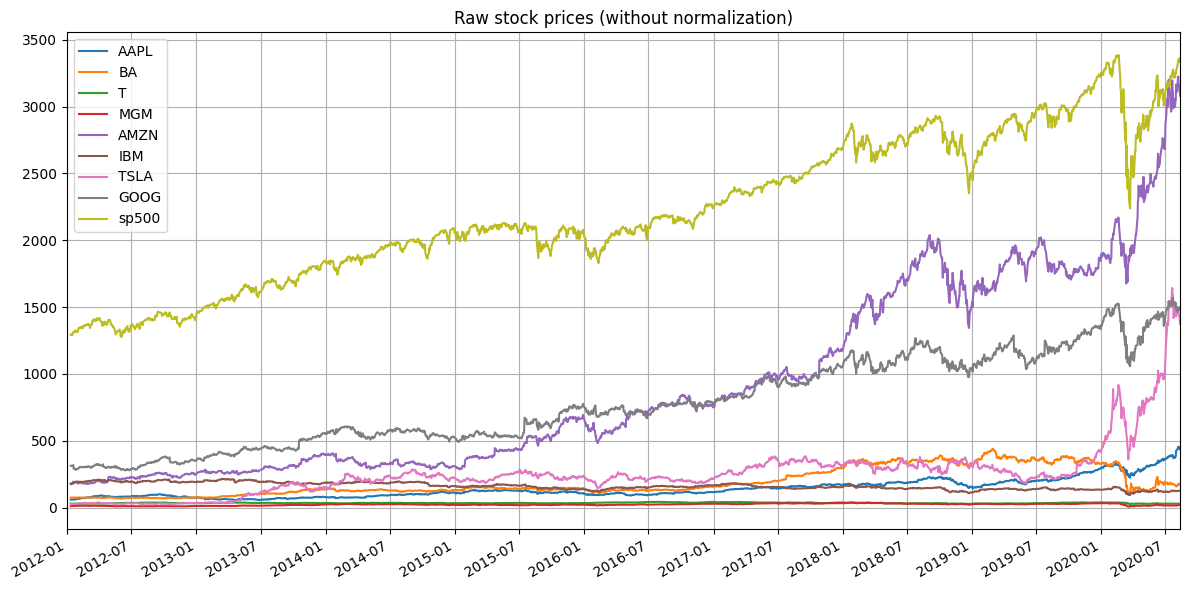

In [13]:
plot(df)

## Task 3. Print out normalized (scaled) stock prices
### 1. Define a function to normalize the prices based on the initial price

In [14]:
def normalize_prices(df, cols):
    df_scaled = df.copy()  # Create a copy of the dataframe to avoid modifying the original
    for col in cols:
        df_scaled[col] = df[col] / df[col].iloc[0]  # Normalize by dividing by the initial price
    return df_scaled

In [15]:
df_scaled = normalize_prices(df, cols)

In [16]:
df_scaled.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2012-01-13,0.996251,0.987949,0.998340,1.018137,1.014153,0.992301,0.806726,0.992615,0.995052
2,2012-01-17,1.007855,0.996424,1.004316,1.009893,1.032570,0.996954,0.941593,0.998317,0.998587
3,2012-01-18,1.018320,0.994040,1.006972,1.049464,1.076792,1.002880,0.949027,1.005193,1.009680
4,2012-01-19,1.015093,1.000662,1.009960,1.055235,1.105269,0.999834,0.947257,1.015771,1.014666


### 2. Plot normalized data

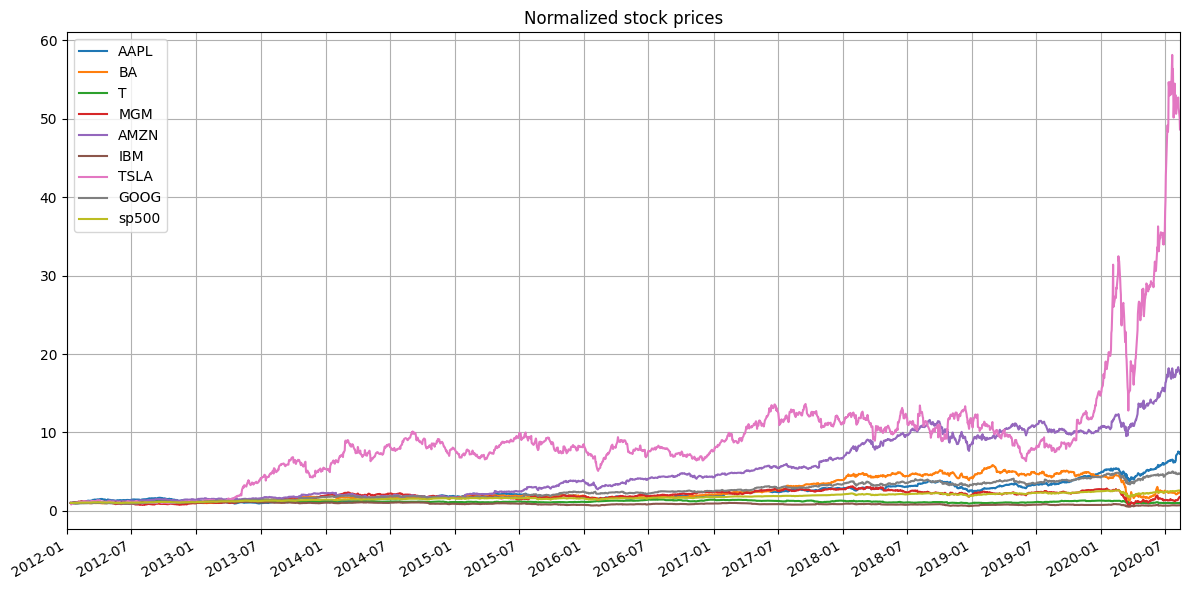

In [17]:
plot(df_scaled, title='Normalized stock prices')

### 3. *Optional:* Define a function to perform an interactive data plotting using plotly express

In [18]:
def plot2(df, title='Normalized stock prices'):
    df['Date'] = pd.to_datetime(df['Date'])
    
    df_melted = df.melt(id_vars='Date', value_vars=[col for col in df.columns if col != 'Date'], var_name='Stock', value_name='Price')
    
    fig = px.line(df_melted, x='Date', y='Price', color='Stock', title=title)
    
    start_date = df['Date'].min()
    start_date_for_ticks = pd.Timestamp(year=start_date.year, month=1, day=1) if start_date.month <= 6 else pd.Timestamp(year=start_date.year, month=6, day=1)
    
    # Set major ticks to every 6 months (January and July)
    fig.update_xaxes(
        dtick='M6',
        tickformat='%Y-%m',
        range=[start_date_for_ticks, df['Date'].max()]
    )

    # Specify the format of the hover information
    fig.update_traces(hovertemplate='Date: %{x|%Y-%m-%d}<br>Price: %{y}')
    
    fig.show()

In [19]:
plot2(df_scaled)

## Task 5. Calculate stock returns
### 1. Define a function to calculate stocks daily returns (for all stocks)

In [20]:
def calculate_daily_returns(df):
    returns = pd.DataFrame(df['Date'])

    for col in cols:
        returns[col] = (df[col] / df[col].shift(1) - 1) * 100 # Multiply by 100 to get percentages

    # Delete the first row since we don't know the returns of the first day
    returns = returns.iloc[1:]

    return returns

In [21]:
returns = calculate_daily_returns(df)

In [22]:
returns.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
1,2012-01-13,-0.374946,-1.205144,-0.166006,1.813685,1.415339,-0.769869,-19.327430,-0.738516,-0.494792
2,2012-01-17,1.164812,0.857909,0.598603,-0.809717,1.815943,0.468852,16.717854,0.574410,0.355295
3,2012-01-18,1.038382,-0.239234,0.264463,3.918367,4.282725,0.594448,0.789470,0.688856,1.110793
4,2012-01-19,-0.316937,0.666134,0.296736,0.549882,2.644634,-0.303752,-0.186494,1.052283,0.493866
5,2012-01-20,-1.741670,-0.052939,0.295858,-1.250000,-1.810236,4.431642,-0.597907,-8.377507,0.066946


### 2. Plot it

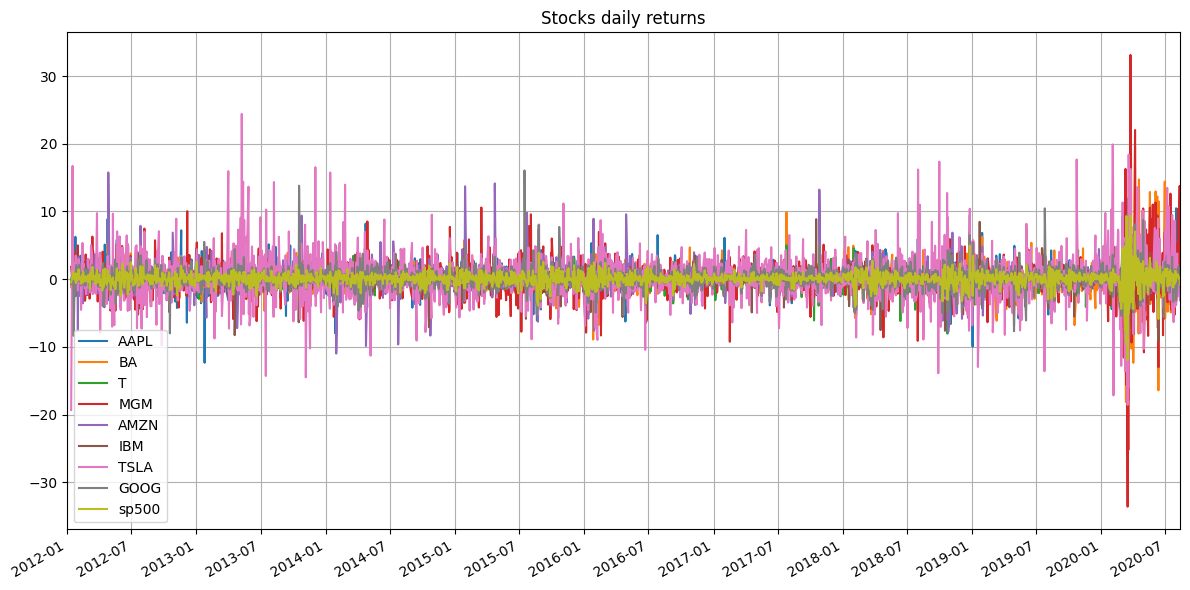

In [23]:
plot(returns, title='Stocks daily returns')

### 3. Calculate the correlations between daily returns

In [24]:
df[cols].corr()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
AAPL,1.000000,0.650275,-0.208947,0.390912,0.938721,-0.726157,0.844056,0.910145,0.892584
BA,0.650275,1.000000,-0.138619,0.746731,0.772300,-0.636949,0.333445,0.822399,0.857329
T,-0.208947,-0.138619,1.000000,0.252347,-0.243089,0.202868,-0.194363,-0.083084,-0.056531
MGM,0.390912,0.746731,0.252347,1.000000,0.468135,-0.479060,0.271630,0.653775,0.713081
AMZN,0.938721,0.772300,-0.243089,0.468135,1.000000,-0.772448,0.760451,0.957678,0.923259
IBM,-0.726157,-0.636949,0.202868,-0.479060,-0.772448,1.000000,-0.610686,-0.813388,-0.795667
TSLA,0.844056,0.333445,-0.194363,0.271630,0.760451,-0.610686,1.000000,0.735988,0.704308
GOOG,0.910145,0.822399,-0.083084,0.653775,0.957678,-0.813388,0.735988,1.000000,0.978315
sp500,0.892584,0.857329,-0.056531,0.713081,0.923259,-0.795667,0.704308,0.978315,1.000000


### 4. Plot the correlation table as in heat-map

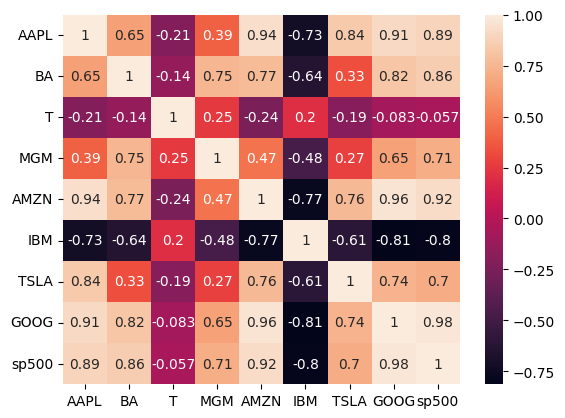

In [25]:
heatmap = sb.heatmap(df[cols].corr(), annot=True)

### 5. What are the top 2 stocks that are positively correlated with the S&P500?

In [26]:
df[cols].corr()['sp500'].nlargest(3)

sp500    1.000000
GOOG     0.978315
AMZN     0.923259
Name: sp500, dtype: float64

The top 2 stocks that are positively correlated with the S&P500 are Alphabet (GOOG) and Amazon (AMZN).

### 6. What is the correlation between Amazon and Boeing? Comment on your answer

In [27]:
df[cols].corr()['AMZN']['BA']

0.7723001896119029

A correlation coefficient of 0.77 is quite high, indicating a strong relationship between the two stocks. This suggests that, as large players in the market, they share systematic risk and are similarly impacted by broader market events, such as geopolitical developments and shifts in investor sentiment.

Despite this correlation, they also face significant idiosyncratic risks due to their distinct sectors and business models. Amazon, a leader in e-commerce and cloud computing, relies heavily on consumer spending and digital demand, while Boeing, central to aerospace and defense, is influenced by defense budgets and airline industry trends. This sectoral divide means that while both stocks might trend similarly due to broad market forces, their individual price movements also reflect unique pressures specific to their industries.

The COVID-19 pandemic illustrated both systematic and idiosyncratic risks: while the overall economy trended downward, Amazon experienced a surge in demand due to lockdowns, whereas Boeing suffered from reduced demand caused by travel restrictions.

### 7. What is the correlation between MGM and Boeing? Comment on your answer

In [28]:
df[cols].corr()['MGM']['BA']

0.7467311905061372

The high correlation between MGM and Boeing also indicates that both companies are susceptible to systemic risk. Economic downturns, interest rate fluctuations, and geopolitical events strongly impact both stocks.

One idiosyncratic risk affecting both companies is travel demand, which influences the volume of tourism for MGM and air travel for Boeing. Additionally, the COVID-19 pandemic demonstrated how both companies could be similarly affected by a major global event, despite their different business focuses. While MGM faced closures of its casinos and hotels due to lockdowns, Boeing saw a sharp decline in aircraft demand as global travel came to a halt.

At the same time, there are distinct industry-specific factors. Firstly, while both companies depend on the regulatory environment, this applies to different sectors: Boeing operates within aviation regulations overseen by entities like the FAA (Federal Aviation Administration) and international aviation authorities, whereas MGM faces specific regulations related to gambling and licensing. Secondly, MGM’s demand is strongly tied to consumer discretionary spending, while Boeing’s demand is largely driven by government defense budgets and the commercial aircraft market.

### 8. Plot the histograms of daily returns and comment

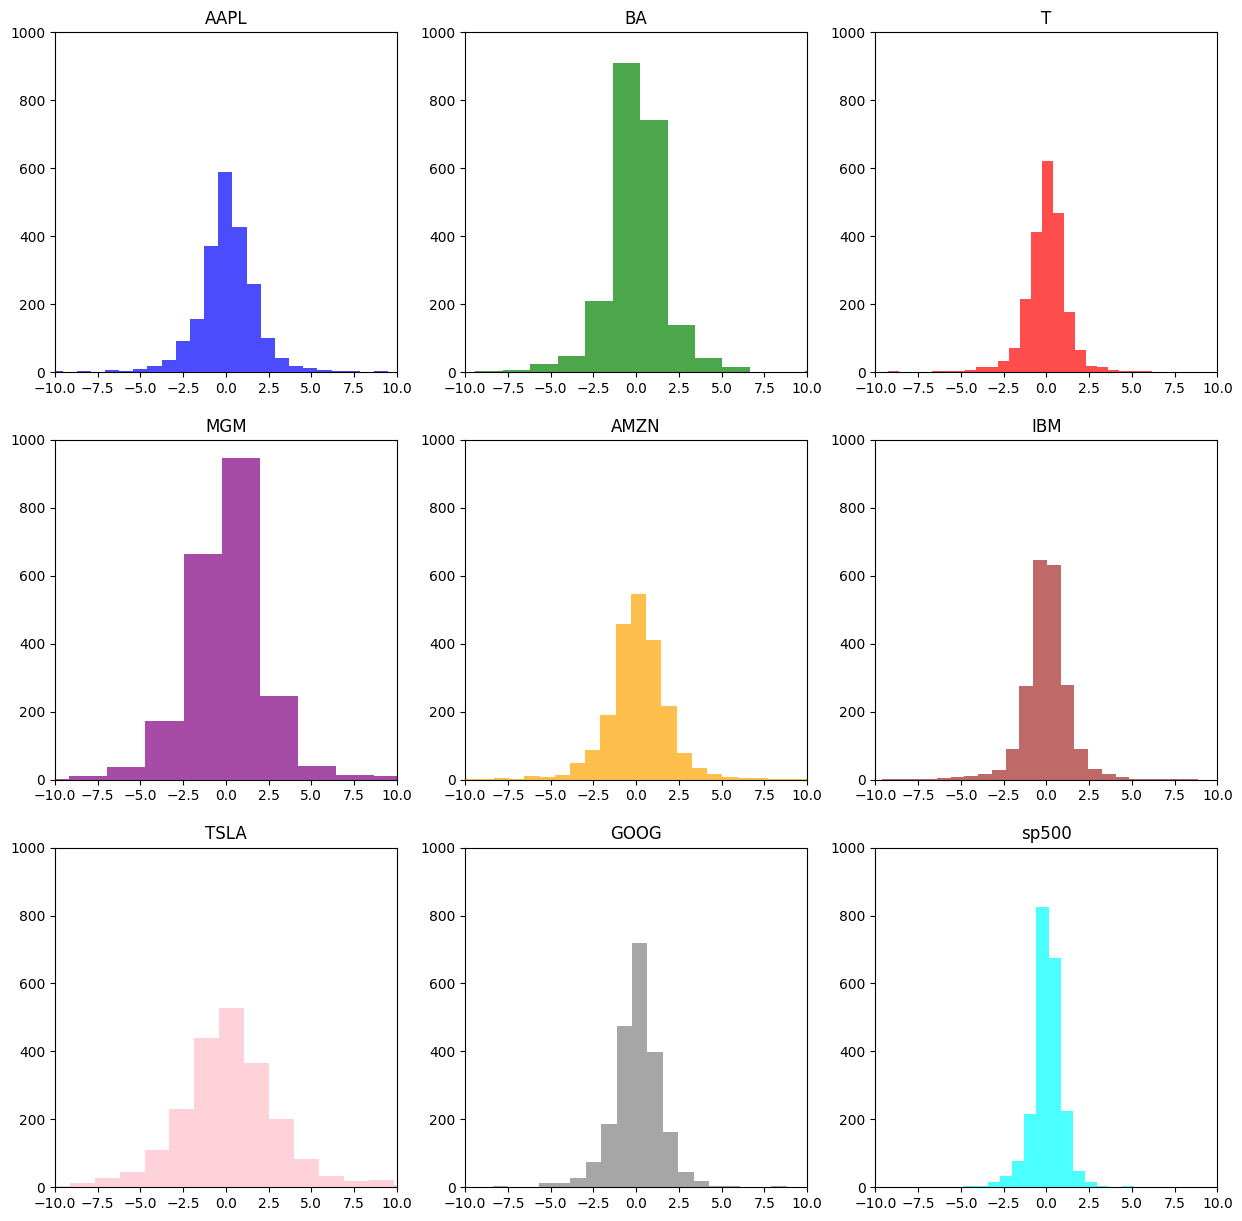

In [29]:
fig, axes = plt.subplots(3, 3,  figsize=(15, 15))

axes = axes.flatten()

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
for i, col in enumerate(cols):
    axes[i].hist(returns[col], alpha=0.7, bins=30, label=col, color=colors[i])
    axes[i].set_title(col)

    # Set the same scale for every subplot so they are comparable
    axes[i].set_xlim(-10, 10)
    axes[i].set_ylim(0, 1000)

plt.show()

### 9. *Optional:* Define a function to perform an interactive and fancy histograms plots using Plotly

In [30]:
fig = px.histogram(returns[cols], marginal='box')
fig.show()

## Task 6. Portfolio weights
### 1. Write a function that will:
<ul>
  <li>Simulate 1000 portfolios with random weights</li>
  <li>Compute the return, the variance and the Sharpe ratio of each portfolio</li>
  <li>Return the maximum Sharpe ratio and its weights</li>
</ul>

In [31]:
stocks = [col for col in cols if col != 'sp500']

In [32]:
def calculate_portfolio_metrics(weights, stocks, returns, risk_free_rate, trading_days=252):
    # We assume that daily returns are IID for simplicity. Thus, we can multiply daily returns by 252 and std by sqrt(252).
    portfolio_return = np.sum(returns[stocks].mean() * weights) * trading_days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns[stocks].cov() * trading_days, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std # Yearly Sharpe ratio
    return portfolio_return, portfolio_std, sharpe_ratio

def generate_portfolios(stocks, returns, num_portfolios, risk_free_rate, trading_days=252, seed=42, return_entire_df=False):
    portfolio_return_record = []
    portfolio_std_record = []
    sharpe_ratio_record = []
    weights_record = []

    np.random.seed(seed)  

    for i in range(num_portfolios):
        weights = np.random.random(len(stocks)) # We are an old-school mutual fund so let's assume long-only portfolio!
        weights /= np.sum(weights)  # Normalize to sum to 1
        weights_record.append(weights)
        
        portfolio_return, portfolio_std, sharpe_ratio = calculate_portfolio_metrics(weights, stocks, returns, risk_free_rate)
        
        portfolio_return_record.append(portfolio_return)
        portfolio_std_record.append(portfolio_std)
        sharpe_ratio_record.append(sharpe_ratio)
        
    portfolio_metrics = pd.DataFrame({
        'Weights': weights_record,
        'Return': portfolio_return_record,
        'Volatility': portfolio_std_record,
        'Sharpe Ratio': sharpe_ratio_record
    })

    best_portfolio = portfolio_metrics.loc[portfolio_metrics['Sharpe Ratio'].idxmax()]

    if return_entire_df:
        return portfolio_metrics, best_portfolio['Sharpe Ratio'], best_portfolio['Weights']
    else:
        return best_portfolio['Sharpe Ratio'], best_portfolio['Weights']

In [33]:
num_portfolios = 20000
risk_free_rate = 0.02

portfolio_metrics, best_portfolio_sharpe_ratio, best_portfolio_weights = generate_portfolios(stocks, returns, num_portfolios, risk_free_rate, trading_days=252, seed=42, return_entire_df=True)

In [34]:
print(best_portfolio_sharpe_ratio, best_portfolio_weights)

1.4537687096835685 [0.22645494 0.05189573 0.01767821 0.01662786 0.39449334 0.0185978
 0.25042393 0.02382818]


In [35]:
portfolio_metrics

,Weights,Return,Volatility,Sharpe Ratio
0,"[0.09622888483605832, 0.2442626914976671, 0.18...",16.663446,22.099791,0.753104
1,"[0.16203901106692983, 0.19087092823876595, 0.0...",24.304458,25.046903,0.969559
2,"[0.10271423501250435, 0.17716131369096302, 0.1...",23.993077,21.676684,1.105938
3,"[0.13524853667334644, 0.23284562344483778, 0.0...",28.726362,25.121238,1.142713
4,"[0.015076952983984754, 0.21992240275482544, 0....",21.935635,23.967877,0.914375
...,...,...,...,...
19995,"[0.017007149127115227, 0.09455128906351976, 0....",26.863510,24.379139,1.101085
19996,"[0.21505820863643316, 0.06710305696968154, 0.2...",18.095503,18.710835,0.966045
19997,"[0.03789066472908269, 0.2730213746676771, 0.13...",18.935795,24.166331,0.782733
19998,"[0.31065499616980663, 0.013066365368909014, 0....",26.388955,22.872274,1.152879


### 2. What are the weights of your tangency portfolio? What would have been the performance of this portfolio over the sample period? Plot it!

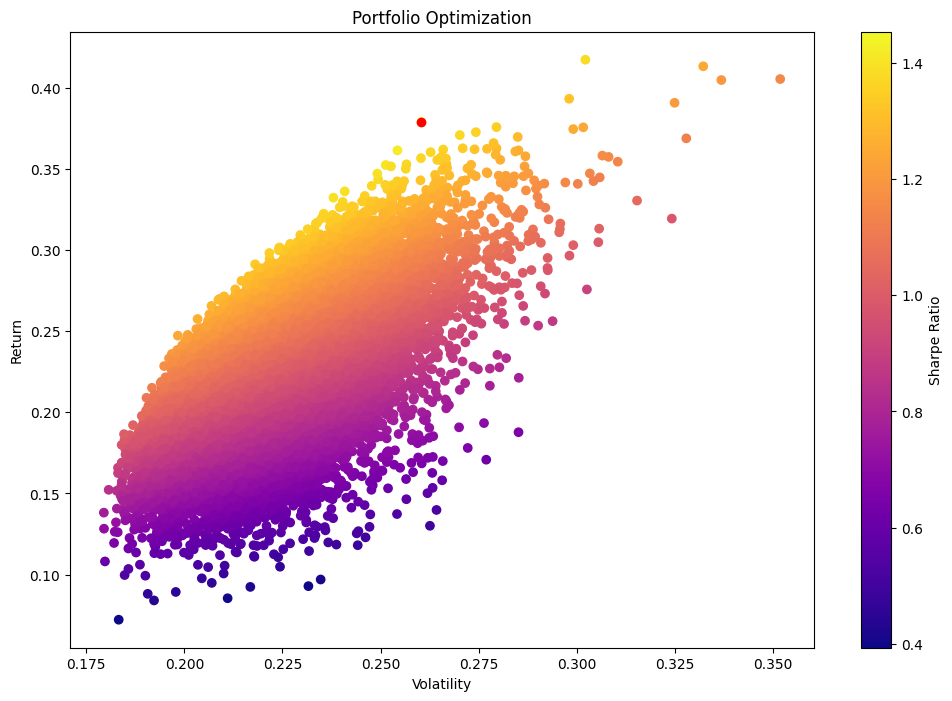

In [36]:
# Choose the portfolio with the maximum Sharpe ratio
max_sharpe = portfolio_metrics.loc[portfolio_metrics['Sharpe Ratio'].idxmax()]

# Plot
plt.figure(figsize=(12,8))
plt.scatter(portfolio_metrics['Volatility'] / 100, portfolio_metrics['Return'] / 100, 
            c=portfolio_metrics['Sharpe Ratio'], cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe['Volatility'] / 100, max_sharpe['Return'] / 100, 
            color='r')
plt.title('Portfolio Optimization')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [37]:
best_weights = {k:v for k, v in zip(stocks, max_sharpe['Weights'])}

print(f'Weights: {best_weights}')
print(f"Return: {max_sharpe['Return']}%")
print(f"Volatility: {max_sharpe['Volatility']}%")
print(f"Sharpe Ratio: {max_sharpe['Sharpe Ratio']}")

Weights: {'AAPL': 0.22645494252440734, 'BA': 0.051895730548139445, 'T': 0.017678212986480868, 'MGM': 0.016627860432776597, 'AMZN': 0.39449334347878534, 'IBM': 0.01859779681204316, 'TSLA': 0.25042393394397705, 'GOOG': 0.023828179273390173}
Return: 37.87873457137692%
Volatility: 26.04178664680254%
Sharpe Ratio: 1.4537687096835685


### 3. *Optional:* Define a function that finds the weights that minimize the variance for all possible level or return (i.e., that draw the efficient frontier). Plot it against the previous scatter plot

In [38]:
def efficient_frontier(stocks, returns, risk_free_rate, num_portfolios=100, seed=42):
    num_assets = len(stocks)
    np.random.seed(seed)

    # Define bounds for stock weights
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    frontier_data = []
    
    # Target returns to build the frontier
    target_returns = np.linspace(0, 100, num_portfolios)
    
    for target in target_returns:
        def portfolio_volatility(weights):
            return calculate_portfolio_metrics(weights, stocks, returns, risk_free_rate)[1]

        constraints_with_target = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.sum(returns[stocks].mean() * x) * 252 - target}
        )
        
        result = minimize(portfolio_volatility, 
                          np.array([1 / num_assets] * num_assets), 
                          bounds=bounds, constraints=constraints_with_target)
        
        ret, vol, sr = calculate_portfolio_metrics(result.x, stocks, returns, risk_free_rate)
        frontier_data.append({'return': ret, 'std': vol, 'sharpe_ratio': sr, 'weights': result.x})
    
    return pd.DataFrame(frontier_data)

In [39]:
efficient_frontier_df = efficient_frontier(stocks, returns, risk_free_rate, num_portfolios=300)

In [40]:
def plot_efficient_frontier(portfolio_metrics, efficient_frontier_df, verbose=False):
    max_sharpe = portfolio_metrics.loc[portfolio_metrics['Sharpe Ratio'].idxmax()]

    plt.figure(figsize=(12,8))

    # Plot random portfolios
    plt.scatter(portfolio_metrics['Volatility'] / 100, portfolio_metrics['Return'] / 100, 
                c=portfolio_metrics['Sharpe Ratio'], cmap='plasma', alpha=0.7)
    plt.colorbar(label='Sharpe Ratio')

    # Save current axis limits to preserve the original plot scale
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()

    # Plot efficient frontier
    plt.plot(efficient_frontier_df['std'] / 100, efficient_frontier_df['return'] / 100, 
            color='blue', linestyle='-', linewidth=2, label='Efficient Frontier')

    # Highlight maximum Sharpe ratio portfolio from random portfolios
    plt.scatter(max_sharpe['Volatility'] / 100, max_sharpe['Return'] / 100, 
                color='red', marker='*', s=200, label='Max Sharpe Ratio (Simulated)')

    max_sharpe_ef = efficient_frontier_df.loc[efficient_frontier_df['sharpe_ratio'].idxmax()]

    # Capital Market Line
    cml_x = np.linspace(0, x_max, 100)
    slope = (max_sharpe_ef['return'] / 100 - risk_free_rate / 100) / (max_sharpe_ef['std'] / 100)
    cml_y = risk_free_rate / 100 + slope * cml_x

    plt.plot(cml_x, cml_y, color='green', linestyle='--', linewidth=2, label='Capital Market Line')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.title('Portfolio Optimization with Efficient Frontier')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    if verbose:
        best_weights = {k:v for k, v in zip(stocks, max_sharpe['Weights'])}

        print(f'Weights: {best_weights}')
        print(f"Return: {max_sharpe['Return']}%")
        print(f"Volatility: {max_sharpe['Volatility']}%")
        print(f"Sharpe Ratio: {max_sharpe['Sharpe Ratio']}")

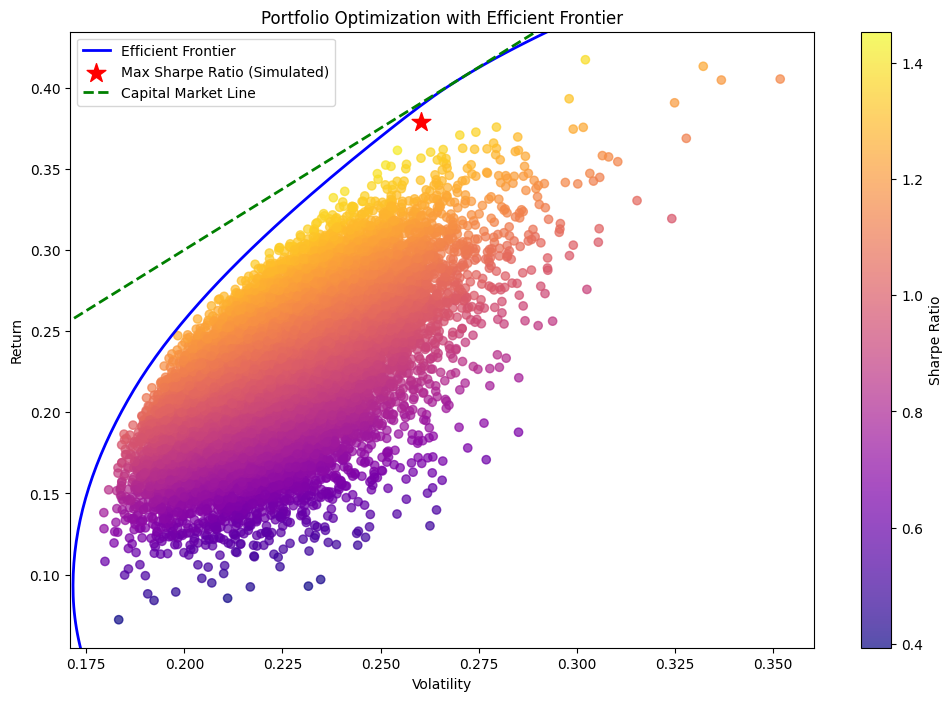

In [41]:
plot_efficient_frontier(portfolio_metrics, efficient_frontier_df)

## Task 7. Testing Portfolio Theory - Optional
### 1. Re-run Task #6 but only on the first part of the sample (2012-2016)
### 2. Find out what are the optimal weights for this period

In [42]:
returns_until_2016 = returns[returns['Date'] <= '2016-12-31']

In [43]:
returns_until_2016

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
1,2012-01-13,-0.374946,-1.205144,-0.166006,1.813685,1.415339,-0.769869,-19.327430,-0.738516,-0.494792
2,2012-01-17,1.164812,0.857909,0.598603,-0.809717,1.815943,0.468852,16.717854,0.574410,0.355295
3,2012-01-18,1.038382,-0.239234,0.264463,3.918367,4.282725,0.594448,0.789470,0.688856,1.110793
4,2012-01-19,-0.316937,0.666134,0.296736,0.549882,2.644634,-0.303752,-0.186494,1.052283,0.493866
5,2012-01-20,-1.741670,-0.052939,0.295858,-1.250000,-1.810236,4.431642,-0.597907,-8.377507,0.066946
...,...,...,...,...,...,...,...,...,...,...
1246,2016-12-23,0.197778,0.222273,0.023406,0.102288,-0.750320,-0.209500,2.345886,-0.170619,0.125172
1247,2016-12-27,0.635088,-0.209113,-0.187217,-1.192101,1.421265,0.257928,2.901473,0.207620,0.224837
1248,2016-12-28,-0.426403,-0.876295,-0.304811,-0.999659,0.094631,-0.568384,0.095662,-0.821174,-0.835653
1249,2016-12-29,-0.025693,-0.262655,0.329257,-0.766013,-0.903990,0.246708,-2.302727,-0.287881,-0.029330


In [44]:
portfolio_metrics_until_2016, _, _ = generate_portfolios(stocks, returns_until_2016, num_portfolios, risk_free_rate, trading_days=252, seed=42, return_entire_df=True)
efficient_frontier_df_until_2016 = efficient_frontier(stocks, returns_until_2016, risk_free_rate, num_portfolios=300)

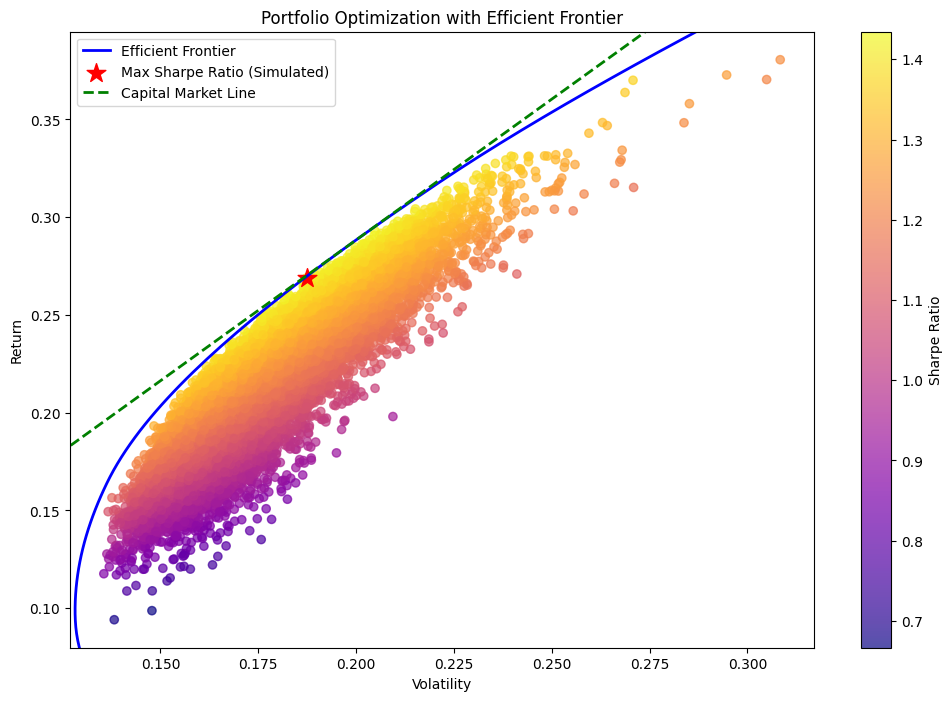

Weights: {'AAPL': 0.10344639929373534, 'BA': 0.1870101920040207, 'T': 0.12039597849490317, 'MGM': 0.0048076730641768515, 'AMZN': 0.24988753156276972, 'IBM': 0.0024603815308801113, 'TSLA': 0.16885042636208544, 'GOOG': 0.1631414176874287}
Return: 26.89226213030396%
Volatility: 18.734147079533557%
Sharpe Ratio: 1.4344000832394994


In [45]:
plot_efficient_frontier(portfolio_metrics_until_2016, efficient_frontier_df_until_2016, verbose=True)

### 3. Simulate your optimal portfolio on the second part of the sample (2016-end)

In [46]:
max_sharpe_until_2016 = portfolio_metrics.loc[portfolio_metrics['Sharpe Ratio'].idxmax()]

In [47]:
returns_from_2017 = returns[returns['Date'] > '2016-12-31']

# Calculate the realized return and volatility using the best weights from the first period
realized_return, realized_volatility, _ = calculate_portfolio_metrics(max_sharpe_until_2016['Weights'], stocks, returns_from_2017, risk_free_rate)

# Get the expected return and volatility from the first period
expected_return = max_sharpe_until_2016['Return']
expected_volatility = max_sharpe_until_2016['Volatility']

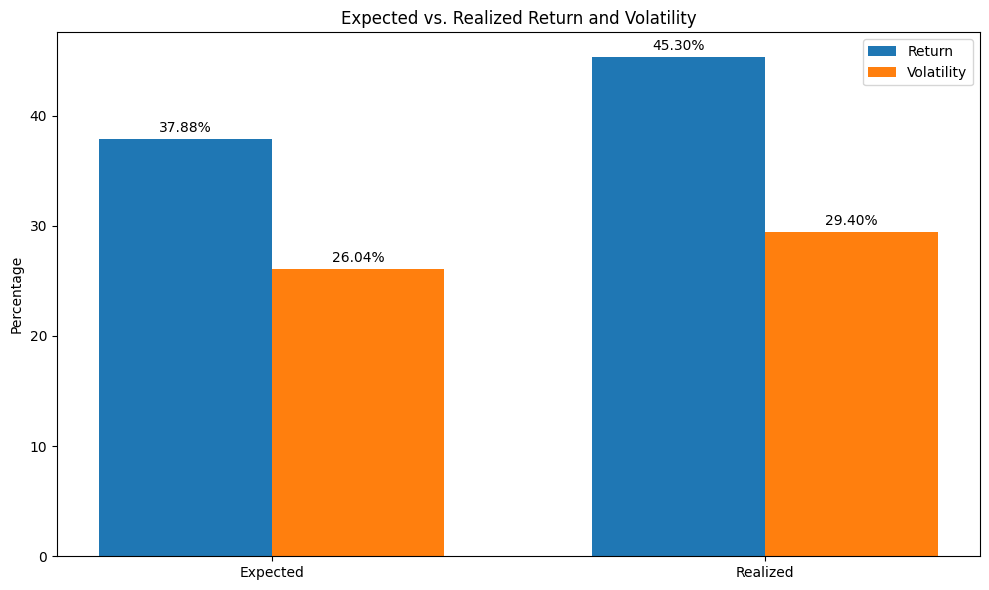

In [48]:
# Bar chart comparison
labels = ['Expected', 'Realized']
returns = [expected_return, realized_return]
volatilities = [expected_volatility, realized_volatility]

x = np.arange(len(labels))  
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width/2, returns, width, label='Return')
rects2 = ax.bar(x + width/2, volatilities, width, label='Volatility')

ax.set_ylabel('Percentage')
ax.set_title('Expected vs. Realized Return and Volatility')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, fmt='%.2f%%', padding=3)
ax.bar_label(rects2, fmt='%.2f%%', padding=3)

plt.tight_layout()
plt.show()